<a href="https://www.kaggle.com/code/ziadhamadafathy/classification-minerals-with-accuracy-86?scriptVersionId=117760346" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob as gb
import cv2
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Preparing data

In [2]:
data = '../input/minerals-identification-classification/Minet 5640 Images/'

In [3]:
for folder in  os.listdir(data): 
    files = gb.glob(pathname= str( data + folder + '/*.jpg'))
    print(f'For data , found {len(files)} in folder {folder}')

For data , found 1155 in folder quartz
For data , found 975 in folder malachite
For data , found 0 in folder Minerals_5640.csv
For data , found 525 in folder chrysocolla
For data , found 1057 in folder pyrite
For data , found 335 in folder muscovite
For data , found 1025 in folder biotite
For data , found 410 in folder bornite


In [4]:
code = {'biotite':0 ,'bornite':1 ,'chrysocolla':2,'malachite':3, 'muscovite':4, 'pyrite':5, 'quartz':6}
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x    

In [5]:
size = []
for folder in  os.listdir(data) : 
    files = gb.glob(pathname= str( data + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts

<bound method IndexOpsMixin.value_counts of 0         (542, 578, 3)
1         (640, 640, 3)
2       (1024, 1024, 3)
3         (384, 400, 3)
4       (1000, 1000, 3)
             ...       
5477      (400, 400, 3)
5478      (454, 500, 3)
5479      (230, 300, 3)
5480     (300, 1300, 3)
5481      (286, 560, 3)
Length: 5482, dtype: object>

In [6]:
s = 224
X_Images = []
y_Types = []
for folder in  os.listdir(data) : 
    files = gb.glob(pathname= str( data + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        info = np.iinfo(image.dtype) # Get the information of the incoming image type
        image = image.astype(np.float64) / info.max # normalize the data to 0 - 1
        image = 255 * image # Now scale by 255
        image = image.astype(np.uint8)
        image_array = cv2.resize(image , (s,s))
        image_array = image_array.astype(np.uint8)
        X_Images.append(list(image_array))
        y_Types.append(code[folder])

In [7]:
print(f'we have {len(X_Images)} items in X_Images')

we have 5482 items in X_Images


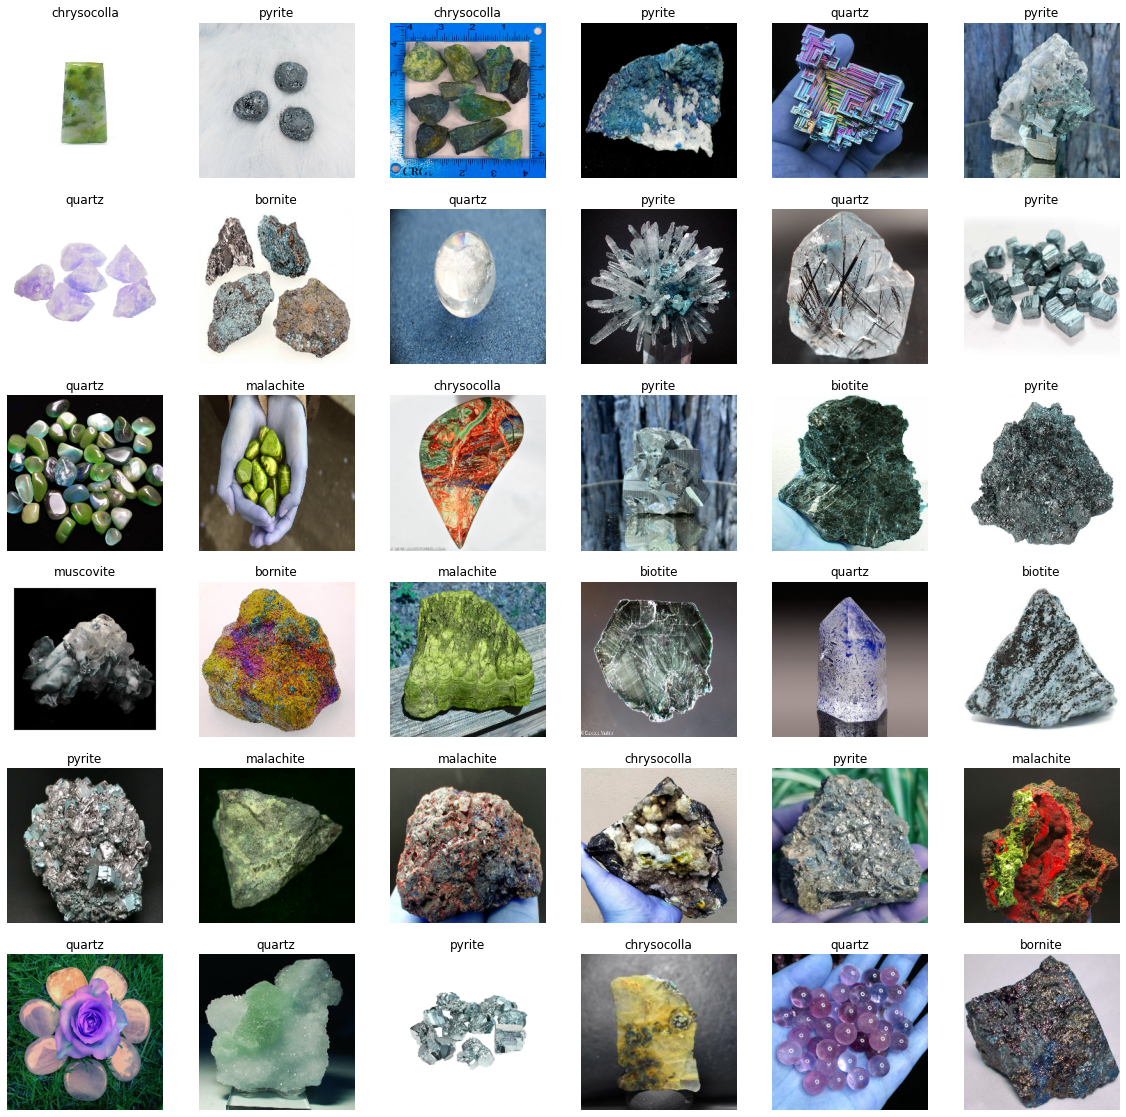

In [8]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_Images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_Images[i])   
    plt.axis('off')
    plt.title(getcode(y_Types[i]))

# Spliting data

In [9]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_Images, y_Types, train_size=0.7, 
                                                    shuffle=True, random_state=100)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.5, 
                                                    shuffle=True, random_state=100)

In [10]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Transfering and Training model

In [11]:
base_model = EfficientNetB1(input_shape = (s, s, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = True

2023-01-30 20:36:30.258363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:36:30.259398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:36:30.443735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:36:30.444615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 20:36:30.445445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

27033600/27018416 [==============================] - 0s 0us/step


In [12]:
KerasModel = Sequential([
    base_model,
    GlobalAveragePooling2D(),    
    Dense(1024,activation="relu"),
    Dropout(0.5),
    Dense(1024,activation="relu"),
    Dropout(0.5),
    Dense(512,activation="relu"),
    Dropout(0.5),
    Dense(256,activation="relu"),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [13]:
opt = keras.optimizers.Adam(learning_rate=0.000025)
KerasModel.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None,

In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)

In [16]:
epochs = 60
ThisModel = KerasModel.fit(X_train,y_train, batch_size=32, epochs=epochs, validation_data=(X_val,y_val),
                           callbacks=[early_stopping], verbose=1)

2023-01-30 20:36:40.975186: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2023-01-30 20:36:54.426206: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


120/120 [==============================] - 81s 468ms/step - loss: 2.0113 - accuracy: 0.1819 - val_loss: 1.8643 - val_accuracy: 0.2762
Epoch 2/60
120/120 [==============================] - 54s 450ms/step - loss: 1.9229 - accuracy: 0.2134 - val_loss: 1.8293 - val_accuracy: 0.3467
Epoch 3/60
120/120 [==============================] - 54s 449ms/step - loss: 1.8903 - accuracy: 0.2280 - val_loss: 1.8007 - val_accuracy: 0.4027
Epoch 4/60
120/120 [==============================] - 54s 453ms/step - loss: 1.8347 - accuracy: 0.2544 - val_loss: 1.7630 - val_accuracy: 0.4453
Epoch 5/60
120/120 [==============================] - 54s 453ms/step - loss: 1.7982 - accuracy: 0.2796 - val_loss: 1.6994 - val_accuracy: 0.5231
Epoch 6/60
120/120 [==============================] - 54s 452ms/step - loss: 1.7288 - accuracy: 0.3112 - val_loss: 1.5969 - val_accuracy: 0.5706
Epoch 7/60
120/120 [==============================] - 54s 452ms/step - loss: 1.6433 - accuracy: 0.3813 - val_loss: 1.4584 - val_accuracy: 0.6

# Accuracy of model

In [17]:
ModelLoss, ModelAccuracy = KerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

26/26 [==============================] - 3s 109ms/step - loss: 0.3000 - accuracy: 0.9320
Test Loss is 0.30000293254852295
Test Accuracy is 0.9319562315940857


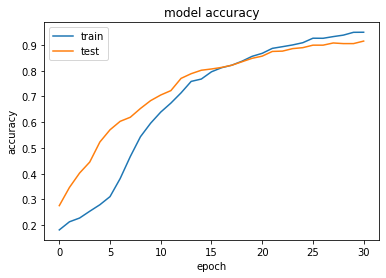

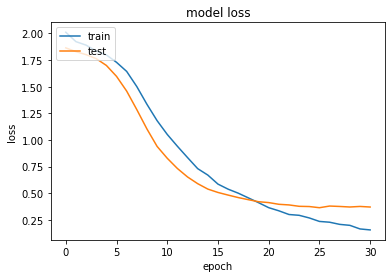

In [18]:
# summarize model for accuracy
plt.plot(ThisModel.history['accuracy'])
plt.plot(ThisModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize model for loss
plt.plot(ThisModel.history['loss'])
plt.plot(ThisModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

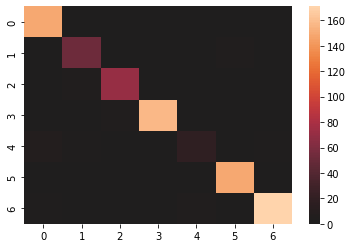

Confusion Matrix is
 [[149   2   0   0   2   0   2]
 [  0  52   2   0   0   5   2]
 [  0   5  71   2   0   0   0]
 [  1   0   5 157   0   0   0]
 [  7   3   0   0  18   1   3]
 [  0   0   1   0   0 149   2]
 [  4   0   1   1   5   0 171]]


In [19]:
y_pred = KerasModel.predict(X_test).argmax(axis=1)
CM = confusion_matrix(y_test, y_pred)

sns.heatmap(CM, center=True)
plt.show()

print('Confusion Matrix is\n', CM)

In [20]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       155
           1       0.84      0.85      0.85        61
           2       0.89      0.91      0.90        78
           3       0.98      0.96      0.97       163
           4       0.72      0.56      0.63        32
           5       0.96      0.98      0.97       152
           6       0.95      0.94      0.94       182

    accuracy                           0.93       823
   macro avg       0.89      0.88      0.89       823
weighted avg       0.93      0.93      0.93       823

0.9319562575941677


In [21]:
# save the model
KerasModel.save('model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Predicting data

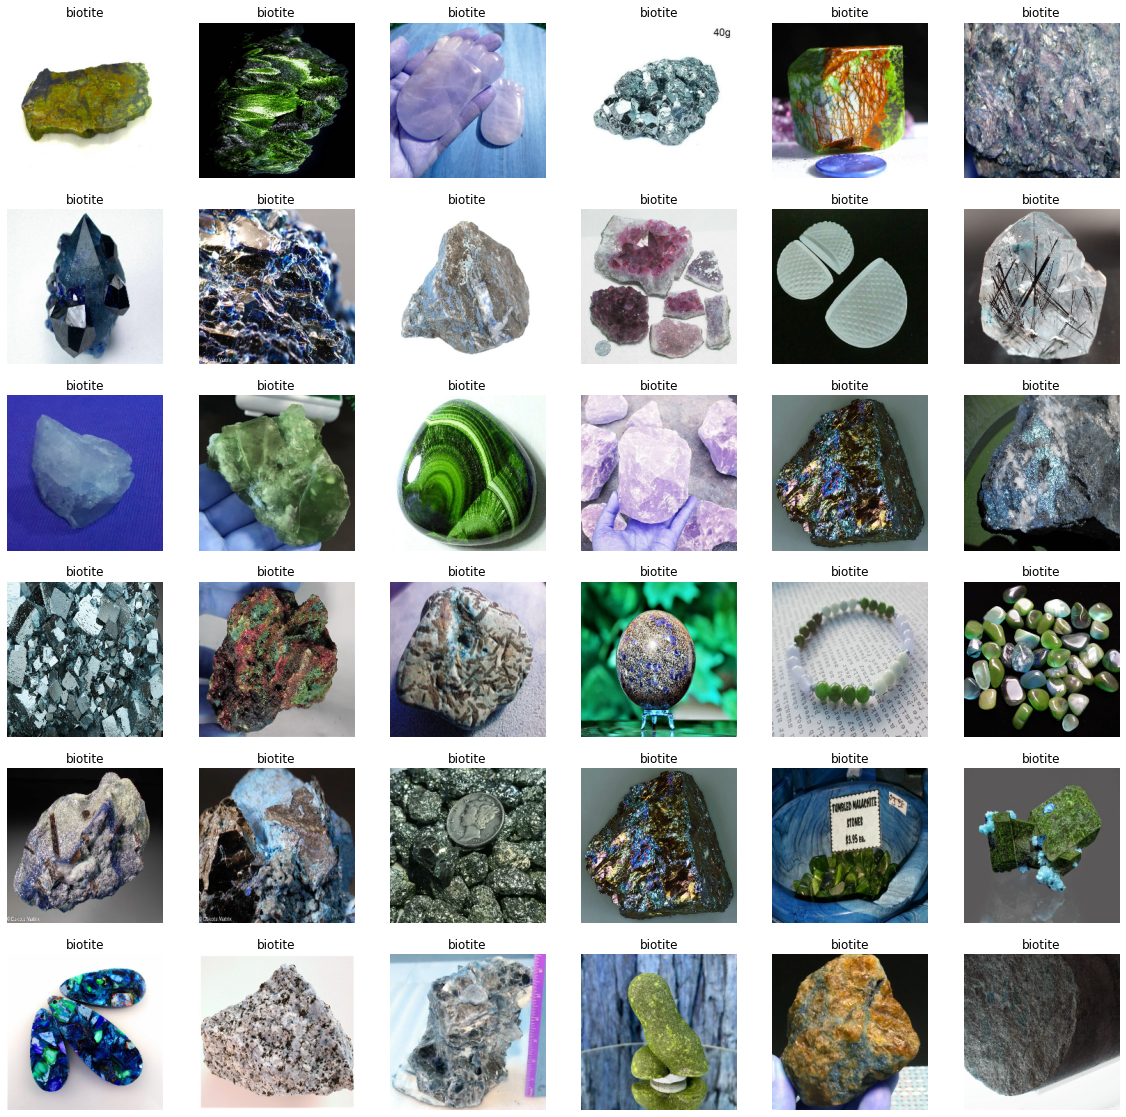

In [22]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_test[i])    
    plt.axis('off')
    plt.title(getcode(np.argmax(y_pred[i])))